In [1]:
!pip install -q -U bitsandbytes --no-index --find-links ../input/llm-detect-pip/
!pip install -q -U transformers --no-index --find-links ../input/libs-install/
!pip install -q -U peft --no-index --find-links ../input/llm-detect-pip/

ERROR: Could not find a version that satisfies the requirement bitsandbytes (from versions: none)
ERROR: No matching distribution found for bitsandbytes
ERROR: Could not find a version that satisfies the requirement peft (from versions: none)
ERROR: No matching distribution found for peft


In [2]:
# 실행 시간 측정을 위해 필요한 라이브러리 불러오기
import time

time_limit = 32100
notebook_start_time = time.time()

# 코드 실행 시간 측정
def elapsed_time():
    return time.time() - notebook_start_time

In [4]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기

In [61]:
# 학습 데이터
train = pd.read_csv("LMSYS_dataset/train.csv")

# 테스트 데이터
test = pd.read_csv("LMSYS_dataset/test.csv")

In [8]:
train.head(3)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1


## EDA
* 데이터셋 확인
* 결측치 확인
* target 및 데이터 시각화

### 데이터 확인

In [12]:
# 데이터 정보 확인
train.info()
print("\n학습 데이터 갯수: ", train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB

학습 데이터 갯수:  (57477, 9)


In [15]:
test.info()
print("테스트 데이터 갯수: ", test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3 non-null      int64 
 1   prompt      3 non-null      object
 2   response_a  3 non-null      object
 3   response_b  3 non-null      object
dtypes: int64(1), object(3)
memory usage: 224.0+ bytes
테스트 데이터 갯수:  (3, 4)


In [18]:
# 결측치 확인
train.isnull().sum()

id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64

In [19]:
test.isnull().sum()

id            0
prompt        0
response_a    0
response_b    0
dtype: int64

In [62]:
# 목표 변수 확인
target_col = ['winner_model_a', 'winner_model_b', 'winner_tie']

for i in target_col:
    print(train[i].value_counts())

winner_model_a
0    37413
1    20064
Name: count, dtype: int64
winner_model_b
0    37825
1    19652
Name: count, dtype: int64
winner_tie
0    39716
1    17761
Name: count, dtype: int64


답변 중 중복 문장 확인

In [63]:
response_df = train[['response_a', 'response_b']]
response_df

,response_a,response_b
0,"[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o..."
1,"[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat..."
2,"[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ..."
3,"[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c..."
4,"[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru..."
...,...,...
57472,"[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig..."
57473,"[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba..."
57474,"[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us..."
57475,"[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or..."


In [ ]:
response_df['response_a'].duplicated().sum()

np.int64(911)

In [65]:
response_df['response_b'].duplicated().sum()

np.int64(868)

답변 문장 길이 확인 (문장 길이 분포 시각화에 사용)

In [76]:
response_df['response_a_len'] = response_df['response_a'].apply(len)
response_df['response_a_len']

C:\Users\mung\AppData\Local\Temp\ipykernel_23752\3443373521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response_df['response_a_len'] = response_df['response_a'].apply(len)


0        4538
1        3114
2         921
3        3182
4        1300
         ... 
57472     396
57473    1707
57474    8683
57475     435
57476      13
Name: response_a_len, Length: 57477, dtype: int64

In [ ]:
response_df['response_b_len'] = response_df['response_b'].apply(len)
response_df['response_b_len']

C:\Users\mung\AppData\Local\Temp\ipykernel_23752\4181108199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response_df['response_b_len'] = a


0        1206
1        3649
2        1835
3        1562
4         772
         ... 
57472     557
57473    1713
57474    1558
57475     969
57476     526
Name: response_b_len, Length: 57477, dtype: int64

사용된 모델명과 사용빈도 확인 (모델 분포 시각화에 사용)

In [45]:
# 모델 a와 모델 b 합친 후 개수 카운트
model_df = pd.concat([train.model_a, train.model_b])
counts = model_df.value_counts().reset_index()

# 모델 이름과 개수 추가
counts.columns = ['LLM', 'Count']

In [46]:
counts

,LLM,Count
0,gpt-4-1106-preview,7387
1,gpt-3.5-turbo-0613,7083
2,gpt-4-0613,6165
3,claude-2.1,5583
4,claude-instant-1,4136
...,...,...
59,falcon-180b-chat,286
60,openchat-3.5-0106,244
61,qwen1.5-7b-chat,208
62,qwen1.5-4b-chat,200


선택된 모델 카운트 (선택 모델 분포 시각화에 사용)

In [47]:
# 모델 중 선택 모델(1인 값) 추출해 class_name 컬럼에 추가
counts["class_name"] = train[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)

# 선택 모델 분포 확인
counts = counts['class_name'].value_counts().reset_index()
counts.columns = ['Winner', 'Win Count']


In [48]:
counts

,Winner,Win Count
0,winner_tie,25
1,winner_model_b,21
2,winner_model_a,18


### 데이터 시각화

문장 길이 분포 시각화

In [80]:
max_len = response_df['response_a_len'].max()
bins = list(range(0, max_len + 500, 500))  # 예: [0, 500, 1000, ..., max_len+500]
labels = [f'{b}-{b+499}' for b in bins[:-1]]

# 구간에 따라 텍스트 길이 분류
response_df['response_a_group'] = pd.cut(response_df['response_a_len'], bins=bins, labels=labels, right=True)

C:\Users\mung\AppData\Local\Temp\ipykernel_23752\723539433.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response_df['response_a_group'] = pd.cut(response_df['response_a_len'], bins=bins, labels=labels, right=True)


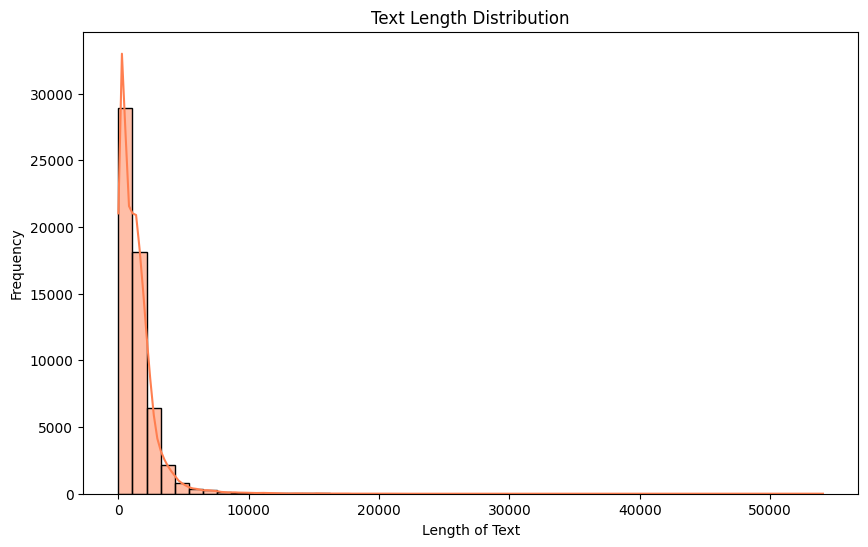

In [81]:
plt.figure(figsize=(10, 6))
sns.histplot(response_df['response_a_len'], bins=50, kde=True, color='coral')
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

In [83]:
df_filtered = response_df[response_df['response_a_len'] < 10000].copy()

bins = list(range(0, 10000, 500))
labels = [f'{b}-{b+499}' for b in bins[:-1]]

df_filtered['a_len_group'] = pd.cut(df_filtered['response_a_len'], bins=bins, labels=labels, right=True)

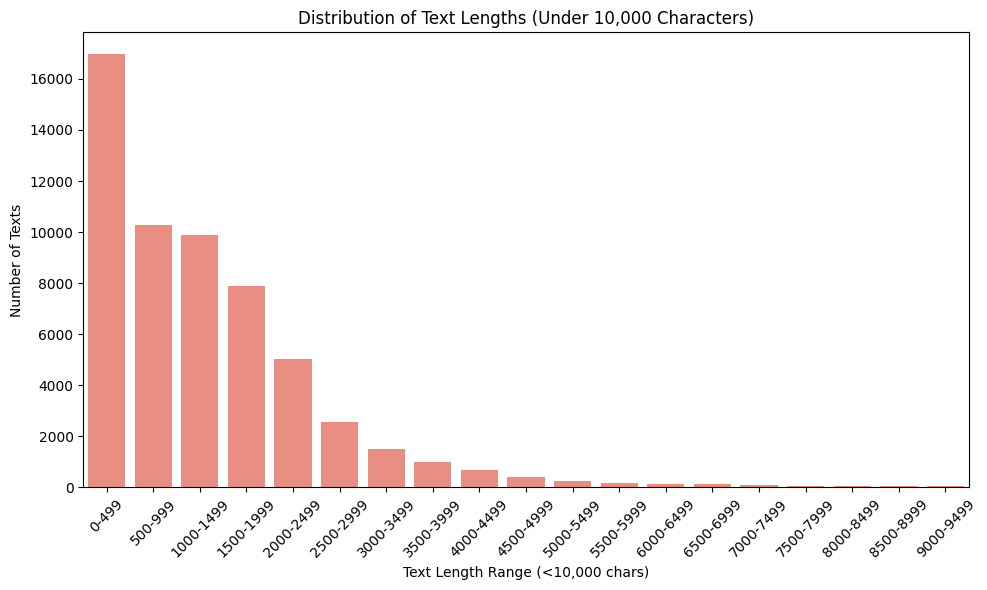

In [84]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x='a_len_group', order=labels, color='salmon')
plt.xticks(rotation=45)
plt.xlabel('Text Length Range (<10,000 chars)')
plt.ylabel('Number of Texts')
plt.title('Distribution of Text Lengths (Under 10,000 Characters)')
plt.tight_layout()
plt.show()

모델 시각화

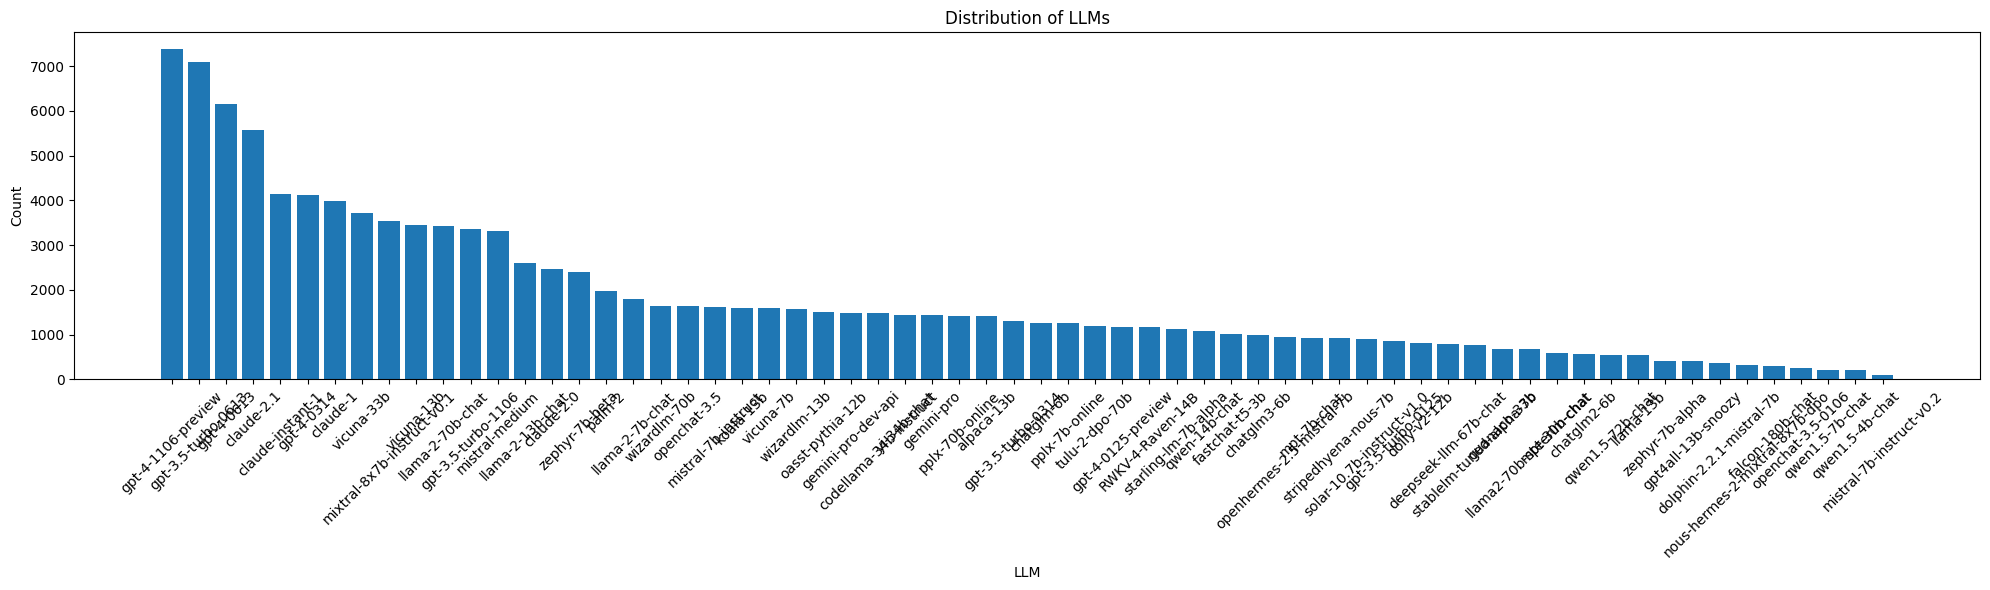

In [33]:
# 사용된 LLM 모델 분포 시각화
plt.figure(figsize=(20, 6))
bars = plt.bar(counts['LLM'], counts['Count'])

plt.title('Distribution of LLMs')
plt.xlabel('LLM')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

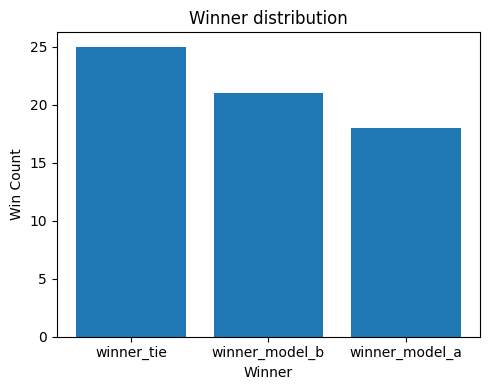

In [88]:
# 모델 a와 모델 b, 무승부 중 선택된 모델 분포 시각화
plt.figure(figsize=(5, 4))
bars = plt.bar(counts['Winner'], counts['Win Count'])

plt.title('Winner distribution')
plt.xlabel('Winner')
plt.ylabel('Win Count')

plt.tight_layout()
plt.show()